In [1]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import pandas as pd
import spacy
import requests
import io
import csv
import matplotlib.pyplot as plt

nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")

In [12]:
def importdata(url):
    response = requests.get(url)
    response.raise_for_status()
    raw_text = response.text

    # Parse CSV 
    reader = csv.reader(io.StringIO(raw_text), delimiter=',', quotechar='"', skipinitialspace=True)
    rows = list(reader)
    max_cols = max(len(r) for r in rows)
    for r in rows:
        while len(r) < max_cols:
            r.append(None)
    df = pd.DataFrame(rows[1:], columns=rows[0])

    print(f"Loaded DataFrame: {len(df)} rows × {len(df.columns)} columns")
    return df

def clean_text(text):
    # Skip non-text values
    if not isinstance(text, str):
        return ""

    # Text formatting
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize, remove stopwords, stem + lemmatize
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    tokens = [stemmer.stem(t) for t in tokens]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)

# Categorize jobs into umbrella titles for easier processing & reading
def categorize_title(title):
    title = str(title).lower()

    if re.search(r'\bscientist(s)?\b', title):
        return 'Data Scientist'
    elif re.search(r'\banalyst(s)?\b', title):
        return 'Data Analyst'
    elif re.search(r'\bengineer(s)?\b', title):
        return 'Data Engineer'
    elif re.search(r'\bcloud(s)?\b', title):
        return 'Cloud Computing'
    elif re.search(r'\bintern(ship|ships)?\b', title):
        return 'Data Science Intern'
    elif re.search(r'\bspecialist(s)?\b', title):
        return 'Data Specialist'
    elif re.search(r'\bmachine learning\b', title) or re.search(r'\bml\b', title):
        return 'Machine Learning Engineer'
    elif re.search(r'\bmanager\b', title):
        return 'Data Manager'
    else:
        return 'Other Data Science Role'
    
# Categorize unknown platforms 
def categorize_platform(platform):
    if not isinstance(platform, str):
        return "Unknown"
    
    platform = platform.lower().strip()

    known_platforms = [
        "linkedin", "indeed", "glassdoor", "ziprecruiter", "simplyhired",
        "salary.com", "monster", "adzuna", "startup jobs", "greenhouse",
        "upwork", "built in", "careerbuilder", "dice", "workday"
    ]

    # If known platform, return proper name
    for known in known_platforms:
            if re.search(rf"\b{re.escape(known)}\b", platform):
                return known.title()
    
    # Otherwise, company website
    if re.search(r'careers?|jobs?|apply', platform):
        return "Company Website"
    
    return "Company Website"
            
    


In [ ]:
# Data loading and column generation
url = "https://raw.githubusercontent.com/MaharLeika18/Data-Mining---Python/refs/heads/Loue/Midterms_Act1/MidtermsExam/Jobs.csv"
df = importdata(url)

df["categorized_title"] = df["title"].apply(categorize_title)
df["description"] = df["description"].apply(clean_text)
df["announcement"] = df["announcement"].apply(categorize_platform)


Loaded DataFrame: 790 rows × 5 columns


In [15]:
# Inspect columns and titles
print(df.columns)
print(df.head(20))

Index(['', 'title', 'company', 'announcement', 'description',
       'categorized_title'],
      dtype='object')
                                                    title  \
0    0         Senior Analyst, Data Science and Analytics   
1    1                              Senior Data Scientist   
2    2                          Lead Data Science Analyst   
3    3                                Data Science Intern   
4    4                                     Data Scientist   
5    5          Senior Solutions Architect (Data Science)   
6    6                              Senior Data Scientist   
7    7  Data Scientist - Research, Development & Const...   
8    8                Data Science Manager - S&A Strategy   
9    9                    Senior/Principal Data Scientist   
10  10                                     Data Scientist   
11  11                               Data Science Analyst   
12  12       Senior Data Scientist - Knowledge Management   
13  13                         Da

In [16]:
# Export dataframe as csv
df.to_csv('ProcessedJobs.csv')

                  Category  Count
0             Data Analyst    388
1           Data Scientist    286
2  Other Data Science Role     44
3          Data Specialist     25
4      Data Science Intern     19
5             Data Manager     16
6            Data Engineer     12


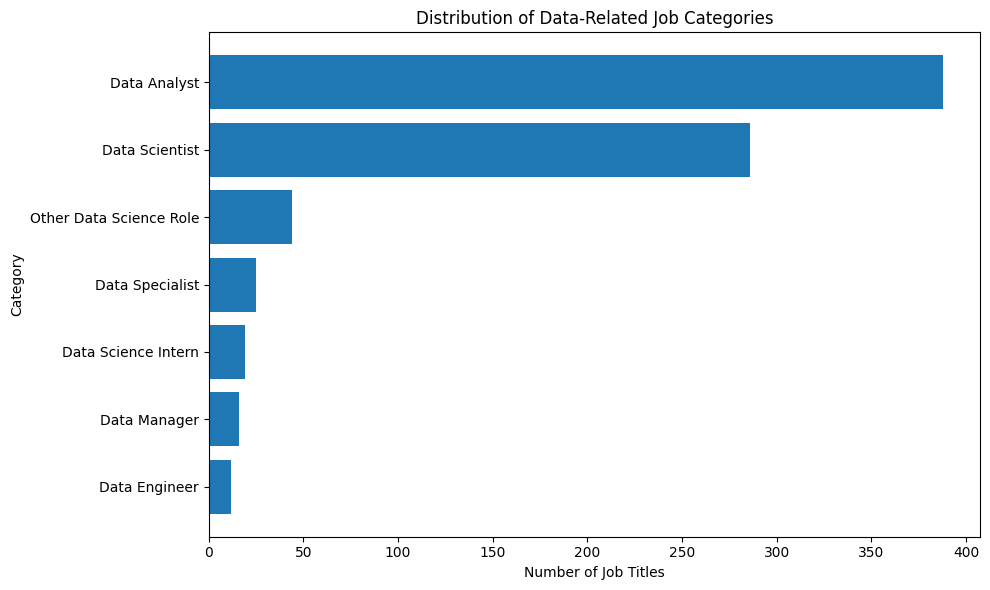

In [6]:
# EDA Visualizations

# Distribution of Job Titles by Category
summary = df["categorized_title"].value_counts().reset_index()
summary.columns = ["Category", "Count"]
print(summary)

plt.figure(figsize=(10,6))
plt.barh(summary["Category"], summary["Count"])
plt.xlabel("Number of Job Titles")
plt.ylabel("Category")
plt.title("Distribution of Data-Related Job Categories")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


                  Category  Count
2  Other Data Science Role     44
3          Data Specialist     25
4      Data Science Intern     19
5             Data Manager     16
6            Data Engineer     12


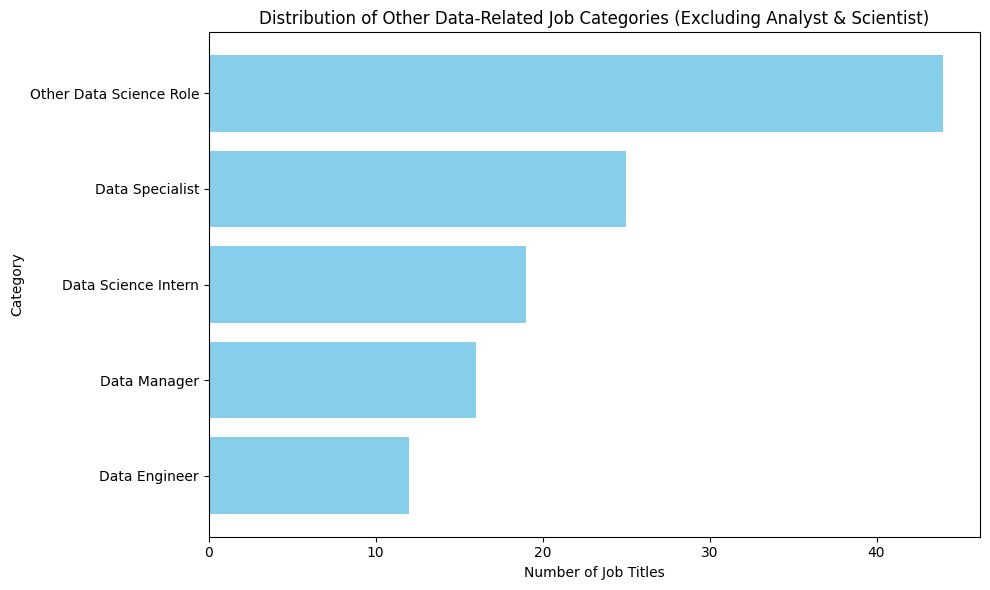

In [7]:

# Distribution of Non-dominant Job Titles by Category
filtered_summary = summary[~summary["Category"].isin(["Data Scientist", "Data Analyst"])]
print(filtered_summary)

plt.figure(figsize=(10,6))
plt.barh(filtered_summary["Category"], filtered_summary["Count"], color='skyblue')
plt.xlabel("Number of Job Titles")
plt.ylabel("Category")
plt.title("Distribution of Other Data-Related Job Categories (Excluding Analyst & Scientist)")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()


          Platform  Count
0  Company Website    292
1         Linkedin    189
2      Simplyhired     79
3     Ziprecruiter     66
4       Salary.Com     41
5         Built In     21
6     Startup Jobs     20
7           Adzuna     20
8        Glassdoor     20
9       Greenhouse     14


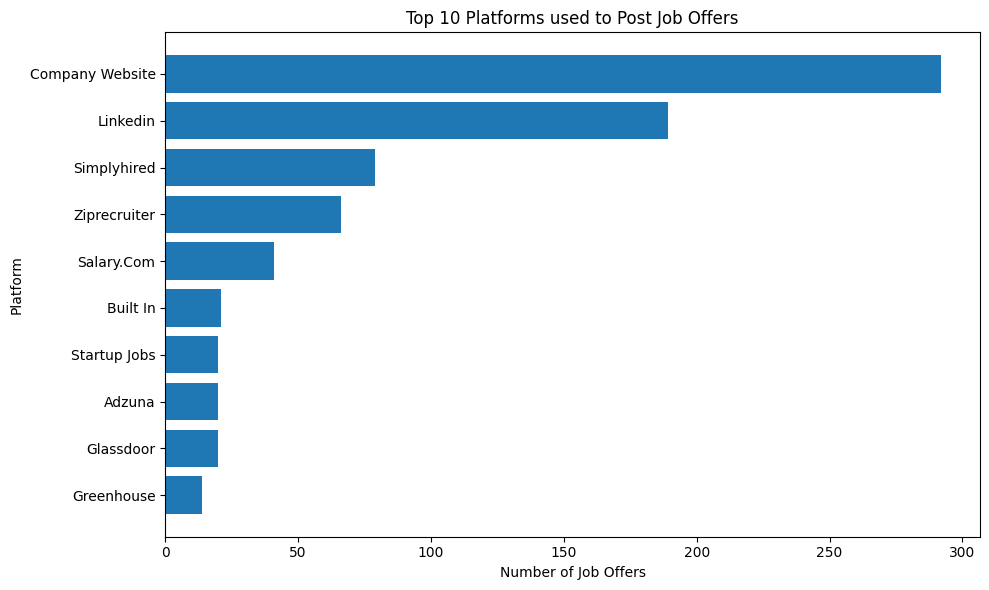

In [17]:
# Distribution of platforms used to post job offers
platforms = df["announcement"].value_counts().reset_index().head(10)
platforms.columns = ["Platform", "Count"]
print(platforms)

plt.figure(figsize=(10,6))
plt.barh(platforms["Platform"], platforms["Count"])
plt.xlabel("Number of Job Offers")
plt.ylabel("Platform")
plt.title("Top 10 Platforms used to Post Job Offers")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


                            Company  Count
0                            Upwork     13
1                           Walmart     12
2                              Dice     10
3               Booz Allen Hamilton     10
4                   Cardinal Health      6
5                     SynergisticIT      5
6          Intermountain Healthcare      4
7  Staffigo Technical Services, LLC      4
8                          Staffigo      4
9                        Guidehouse      4


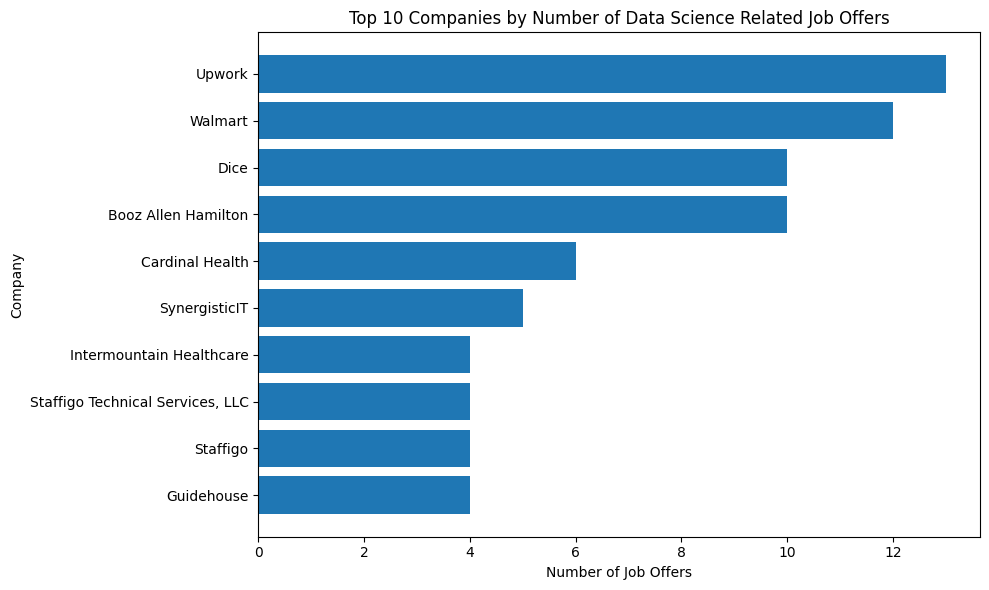

In [9]:
# Top Companies with most number of Data Science Related Job Offers
companies = df["company"].value_counts().reset_index().head(10)
companies.columns = ["Company", "Count"]
print(companies)

plt.figure(figsize=(10,6))
plt.barh(companies["Company"], companies["Count"])
plt.xlabel("Number of Job Offers")
plt.ylabel("Company")
plt.title("Top 10 Companies by Number of Data Science Related Job Offers")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
